# Classifying Glioblastoma cells based on developmental cell type resemblance: an analysis of the predictions

During my internship, I have generated some predictions for a large scRNAseq dataset of Glioblastoma Multiforme dataset, based on their resemblance with a scRNAseq meta-atlas of the developing brain. These predictions have been generated through two main models: a Random Forest Classifier and a Mahalanobis distance-based classifier method. I loaded the data in MySQL workbench, and here I am analysing the results of my work.

I would have loved to repeat the entire classification process! But apparently I couldn't download scikit-learn on this virtual machine. My goal with this notebook is the analysis of my data, which has been a crucial part of my internship.

In [1]:
import MySQLdb
from MySQLdb import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mySchema = "scRNAseq_GBM_classifier"

In [3]:
db = connect(
    host="localhost",
    user="root",
    passwd="ubc",
    db=mySchema
)

In [4]:
cursor = db.cursor(MySQLdb.cursors.DictCursor)

print("connection and cursor are ready")

connection and cursor are ready


### Check if the database contains the correct number of cells
I had to create a very small subset of the original datasets for both training dataset (HealthyCell) and test dataset (TumorCell), because this device has a limited capacity. The main problem is the expression data, that in the database represents the many to many relationship between cells and genes, so it has n of rows in healthy/tumor cell x n of rows in gene. Specifically, I selected about 15000 cells for the training and about 4000 for the test, meaning a single sample. In this query, I check that the number of healthy and tumor cells, is matching my expectations:

**description of the query**: The query counts and returns the number of cells for each cell type in the Cell table, grouped by Cell_Type.

In [5]:
query_counts = """
SELECT Cell_Type, COUNT(*) AS n_cells
FROM Cell
GROUP BY Cell_Type
"""

df_counts = pd.read_sql(query_counts, db)
print(df_counts)

  Cell_Type  n_cells
0   Healthy    15607
1     Tumor     3798


### Check if the database contains more or less the same number of cells for each cell type
I learned through experience that this is very important for the classifier. So, I created the subset of the training dataset in such a way that it contains more or less 2000 cells for each cell type, to have a balanced number of cells for each label for the predictions:

**description of the query**: Also here, the query counts and returns the number of cells for each annotated cell type in the HealthyCell table, and groupes it by cell class.

In [6]:
query_counts_annot = """
SELECT Annotations, COUNT(*) AS n_cells
FROM HealthyCell
GROUP BY Annotations
"""

df_counts_annot = pd.read_sql(query_counts_annot, db)
print(df_counts_annot)

         Annotations  n_cells
0         Astrocytes     2000
1  early Radial Glia     2000
2   late Radial Glia     2000
3               nIPC     2000
4                OPC     2000
5     pre-astrocytes     2000
6            pre-OPC     1607
7   subcortical nIPC     2000


### Inspecting a potential bias in the classifications. Is the outcome strongly correlated to the dissociation type?
In this query, my aim was to see if single nuclei and single cell dissociation types were receiving consistently different predictions. Unfortunately, for memory issues I could load just one sample, that, in this case, had cells processed only with the single cell dissociation techniques.

**description of the query**: The query retrieves the number of tumor cells categorized by their dissociation method and their corresponding Random Forest predicted labels. It joins the TumorCell table with the Predictions table on Cell_ID. Then, it groups the results by Dissociation and Random_Forest to count the cells in each category.

In [7]:
query_dissociation = """ 
SELECT
    tc.Dissociation,
    p.Random_Forest,
    COUNT(tc.Cell_ID) AS n_cells
FROM
    TumorCell tc
JOIN
    Predictions p ON tc.Cell_ID = p.Cell_ID
GROUP BY
    tc.Dissociation,
    p.Random_Forest
"""

df_diss = pd.read_sql(query_dissociation, db)
print(df_diss)

  Dissociation      Random_Forest  n_cells
0         Cell         Astrocytes      915
1         Cell  early Radial Glia      985
2         Cell   late Radial Glia      590
3         Cell               nIPC       88
4         Cell                OPC      228
5         Cell     pre-astrocytes      385
6         Cell            pre-OPC       44
7         Cell   subcortical nIPC      563


**description of the query**: this query selects the dissociation column from the TumorCell table and the total number of cells in that table. Then, it calculates the percentage of cells in the current group relative to all TumorCells with dissociation labeled as 'Cell' or 'Nuclei', rounded to two decimal places.

In [8]:
query_perc_diss = """
SELECT
    tc.Dissociation,
    COUNT(*) AS n_cells,
    ROUND((COUNT(*) / (SELECT COUNT(*) FROM TumorCell WHERE Dissociation IN ('Cell', 'Nuclei'))) * 100, 2) AS percentage
FROM
    TumorCell tc
WHERE
    tc.Dissociation IN ('Cell', 'Nuclei')
GROUP BY
    tc.Dissociation

"""
df_perc_diss = pd.read_sql(query_perc_diss, db)
print(df_perc_diss)

  Dissociation  n_cells  percentage
0         Cell     3798       100.0


As I anticipated, the sample I imported contains only Cell dissociation type. It would have been really useful on the whole dataset though,
since I didn´t have time to correlate the predictions with the dissociation type to detect potential biases during the course of my internship.

### Analysing the results of my classifiers
Here I wanted to inspect the results of my classifier. To do so, I counted how many cells for each annotation type were predicted by both classifiers.

**description of the query**: This query does twice the same thing, first with Random_Forest, then with Mahalanobis, and then it unites the two results.
It select the predictions and the number of cells from the table predictions, and groups these predictions by cell class in the current prediction method.

In [9]:
query_pred_distribution = """
SELECT 
    'Random_Forest' AS method,
    P.`Random_Forest` AS prediction,
    COUNT(*) AS count_cells
FROM 
    Predictions P

GROUP BY 
    P.`Random_Forest`
    
UNION ALL

SELECT 
    'Mahalanobis' AS method,
    P.`Mahalanobis` AS prediction,
    COUNT(*) AS count_cells
FROM 
    Predictions P
GROUP BY 
    P.`Mahalanobis`
ORDER BY 
    method, count_cells DESC
"""

df_pred_distribution = pd.read_sql(query_pred_distribution, db)
print(df_pred_distribution)

           method         prediction  count_cells
0     Mahalanobis         Astrocytes         2096
1     Mahalanobis     pre-astrocytes         1174
2     Mahalanobis                OPC          451
3     Mahalanobis   subcortical nIPC           47
4     Mahalanobis            pre-OPC           18
5     Mahalanobis   late Radial Glia           11
6     Mahalanobis               nIPC            1
7   Random_Forest  early Radial Glia          985
8   Random_Forest         Astrocytes          915
9   Random_Forest   late Radial Glia          590
10  Random_Forest   subcortical nIPC          563
11  Random_Forest     pre-astrocytes          385
12  Random_Forest                OPC          228
13  Random_Forest               nIPC           88
14  Random_Forest            pre-OPC           44


In general, the result of my research shows that while some tumor mimic specific developmental cell types, mainly Astrocytes, pre-Astrocytes and Oligodendrocyte Precursor Cell, others, included this one, showed strong inconsistency across the two classifiers. This was due to the fact that this sample consists mainly of cells in transitional or hybrid states, with transcriptional profiles extremely different with the training dataset. The two different classification methods interpret differently these ambiguous signals.

### Plot of the previous results

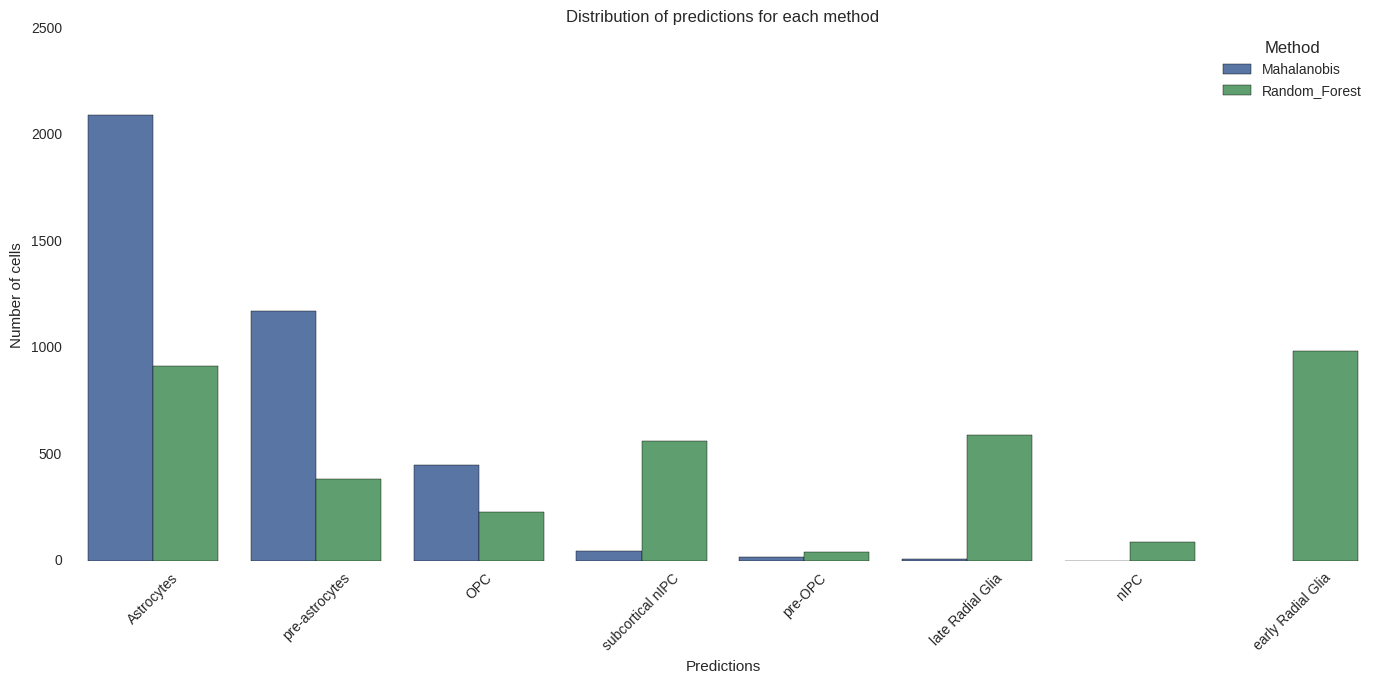

In [10]:
import seaborn as sns
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_pred_distribution, x='prediction', y='count_cells', hue='method')

ax.patch.set_facecolor('white') 
plt.gcf().set_facecolor('white')
plt.title('Distribution of predictions for each method')
plt.xlabel('Predictions')
plt.ylabel('Number of cells')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()
plt.show()


### Computing the percentage of matching predictions

**description of the query**: The query returns the number of time the column Random Forest and Mahalanobis returns the same output, plus the total number of cells in the predictions table.

In [11]:
query_matching = """
SELECT 
    SUM(CASE WHEN P.`Random_Forest` = P.Mahalanobis THEN 1 ELSE 0 END) AS matching,
    COUNT(*) AS total
FROM Predictions P
"""

df_match = pd.read_sql(query_matching, db)
print(df_match)
matching = df_match.loc[0, 'matching']
total = df_match.loc[0, 'total']
perc = (total/matching)*10
perc

   matching  total
0    1033.0   3798


36.766698935140369

This result is way below the average of the entire dataset, which value is around 65 percent.

### Checking the gene expression of some marker genes in each predicted category for Random Forest classifier
#### AQP4
What I would like to see here is that this gene is significantly more expressed in Astrocytic like tumor cells rather than OPC-like tumor cells. It would mean that my classifier (in this case, Random Forest), is able to recognize AQP4 as a marker gene for the correct class.
To be fair, it would have been much more informative if I had the normalized data. However, I had the habit of normalizing the dataset only if needed, and to save on disk only the raw data.

**description of the query**: The query selects the column Random_Forest from the Predictions table only if the predictions is Astrocytes or OPC, and the sparse raw counts from the TumorCell_GeneExpression table only if the gene name is AQP4, then it joins the two tabels on Cell_ID.

In [12]:
query_expr_AQP4 = """
SELECT 
    P.`Random_Forest` AS predicted_label,
    TCE.Sparse_Raw_Counts
FROM TumorCell_GeneExpression TCE
JOIN Predictions P ON TCE.Cell_ID = P.Cell_ID
WHERE 
    TCE.Gene_Name = 'AQP4'
    AND (P.`Random_Forest` = 'Astrocytes' OR P.`Random_Forest` = 'OPC')
"""

df_expr_AQP4  = pd.read_sql(query_expr_AQP4, db)
df_expr_AQP4.groupby("predicted_label")["Sparse_Raw_Counts"].describe()

predicted_label       
Astrocytes       count    307.000000
                 mean       1.885993
                 std        1.344329
                 min        0.000000
                 25%        1.000000
                 50%        2.000000
                 75%        3.000000
                 max        7.000000
OPC              count     38.000000
                 mean       2.421053
                 std        1.670598
                 min        0.000000
                 25%        2.000000
                 50%        2.000000
                 75%        3.000000
                 max        7.000000
Name: Sparse_Raw_Counts, dtype: float64

NB: Before submitting, I generated fake data, because the dataset is still confidential. Before putting the fake data into the machine, I used the real data to generate the statitics. They are:

Astrocytes       count    307.000000
                 mean       9.348534
                 std       17.497872
                 min        1.000000
                 25%        1.000000
                 50%        2.000000
                 75%       10.000000
                 max      123.000000
OPC              count     38.000000
                 mean       1.184211
                 std        0.392859
                 min        1.000000
                 25%        1.000000
                 50%        1.000000
                 75%        1.000000
                 max        2.000000
 
so, looking at the mean, AQP4 is more expressed on Astrocytes predicted cells than OPCs predicted cells.

#### HOPX
This gene is one of the very few known genes able to distinguish between early and late radial glia, since it is a late radial glia marker.

In [13]:
query_expr_HOPX = """
SELECT 
    P.`Random_Forest` AS predicted_label,
    TCE.Sparse_Raw_Counts
FROM TumorCell_GeneExpression TCE
JOIN Predictions P ON TCE.Cell_ID = P.Cell_ID
WHERE 
    TCE.Gene_Name = 'HOPX'
    AND (P.`Random_Forest` = 'late Radial Glia' OR P.`Random_Forest` = 'early Radial Glia')
"""

df_expr_HOPX  = pd.read_sql(query_expr_HOPX, db)
#print(df_expr_HOPX)
df_expr_HOPX.groupby("predicted_label")["Sparse_Raw_Counts"].describe()

predicted_label         
early Radial Glia  count    16.000000
                   mean      2.187500
                   std       1.470544
                   min       0.000000
                   25%       1.750000
                   50%       2.000000
                   75%       3.000000
                   max       5.000000
late Radial Glia   count    44.000000
                   mean      1.727273
                   std       1.207797
                   min       0.000000
                   25%       1.000000
                   50%       2.000000
                   75%       3.000000
                   max       5.000000
Name: Sparse_Raw_Counts, dtype: float64

Here, the real data is:

early Radial Glia  count    16.000000
                   mean      1.937500
                   std       2.080665
                   min       1.000000
                   25%       1.000000
                   50%       1.000000
                   75%       2.000000
                   max       9.000000
late Radial Glia   count    44.000000
                   mean      3.068182
                   std       3.230651
                   min       1.000000
                   25%       1.000000
                   50%       1.500000
                   75%       4.000000
                   max      16.000000
                 
looking at the mean, we can see that this gene is not very expressed in the tumor, but more than twice in the late radial glia predicted cells rather than in the early Radial Glia!

### HOPX expression in the healthy cells
Just to confirm that it is a good marker gene for the late Radial Glia class.

In [14]:
query_expr_HOPX2 = """
SELECT 
    HC.`Annotations` AS cell_class,
    HCE.Sparse_Raw_Counts
FROM HealthyCell_GeneExpression HCE
JOIN HealthyCell HC ON HCE.Cell_ID = HC.Cell_ID
WHERE 
    HCE.Gene_Name = 'HOPX'
    AND (HC.`Annotations` = 'late Radial Glia' OR HC.`Annotations` = 'early Radial Glia')
"""

df_expr_HOPX2  = pd.read_sql(query_expr_HOPX2, db)
df_expr_HOPX2.groupby("cell_class")["Sparse_Raw_Counts"].describe()

cell_class              
early Radial Glia  count     179.000000
                   mean        1.189944
                   std         0.701291
                   min         0.000000
                   25%         1.000000
                   50%         1.000000
                   75%         1.000000
                   max         5.000000
late Radial Glia   count    1024.000000
                   mean        3.259766
                   std         3.904393
                   min         0.000000
                   25%         1.000000
                   50%         2.000000
                   75%         4.000000
                   max        34.000000
Name: Sparse_Raw_Counts, dtype: float64

I didn´t alter the training data


### AQP4 expression in the tumor cells for the Mahalanobis distance-based predictions.
We have seen that the Random Forest classifier calls Astrocytic-like cells that have actually a higher expression of AQP4 respect to the cells that are classified as OPC-like. Let's see how the Mahalanobis distance-based classifier does.

In [15]:
query_expr_AQP4M = """
SELECT 
    P.`Mahalanobis` AS predicted_label,
    TCE.Sparse_Raw_Counts
FROM TumorCell_GeneExpression TCE
JOIN Predictions P ON TCE.Cell_ID = P.Cell_ID
WHERE 
    TCE.Gene_Name = 'AQP4'
    AND (P.`Mahalanobis` = 'Astrocytes' OR P.`Mahalanobis` = 'OPC')
"""

df_expr_AQP4M  = pd.read_sql(query_expr_AQP4M, db)
df_expr_AQP4M.groupby("predicted_label")["Sparse_Raw_Counts"].describe()

predicted_label       
Astrocytes       count    397.000000
                 mean       1.909320
                 std        1.318799
                 min        0.000000
                 25%        1.000000
                 50%        2.000000
                 75%        3.000000
                 max        7.000000
OPC              count     53.000000
                 mean       2.000000
                 std        1.330124
                 min        0.000000
                 25%        1.000000
                 50%        2.000000
                 75%        3.000000
                 max        6.000000
Name: Sparse_Raw_Counts, dtype: float64

Real data statistics: Astrocytes       count    397.000000
                 mean       7.471033
                 std       15.769722
                 min        1.000000
                 25%        1.000000
                 50%        1.000000
                 75%        5.000000
                 max      123.000000
OPC              count     53.000000
                 mean       1.075472
                 std        0.266679
                 min        1.000000
                 25%        1.000000
                 50%        1.000000
                 75%        1.000000
                 max        2.000000

### Plotting UMAP of the training dataset, colored by cell class.
Umaps visualizations are one of the most powerful tool for manual annotation. It really helped me to annotate the cells of the training dataset, plotting on the Umap the normalized expression of the marker genes.
Here I show you the final annotation of the cells.
a small disclaimer is that this UMAP has been computed before the addition of the subcortical nIPC class, so I will not plot the cells of this class because the coordinates for that class belong to another analysis, and so the subspace is not the same. 

**description of the query**: this query select the Cell_ID, annotations, and UMAP coordinates for all healthy cells, excluding those annotated as 'subcortical nIPC'. It does this by joining the HealthyCell, and UMAP tables twice, once for each dimension to plot, based on the Cell_ID.

In [16]:
query_healthy_UMAP = """
SELECT 
    hc.Cell_ID, 
    hc.Annotations, 
    um1.Coordinate AS DIM1, 
    um2.Coordinate AS DIM2
FROM 
    HealthyCell hc
JOIN 
    UMAP um1 
    ON hc.Cell_ID = um1.Cell_ID AND um1.DIM = 'DIM1'
JOIN 
    UMAP um2 
    ON hc.Cell_ID = um2.Cell_ID AND um2.DIM = 'DIM2'
WHERE 
    hc.Annotations != 'subcortical nIPC'
"""

df_healthy_UMAP = pd.read_sql(query_healthy_UMAP, db)

/usr/local/lib/python3.5/dist-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


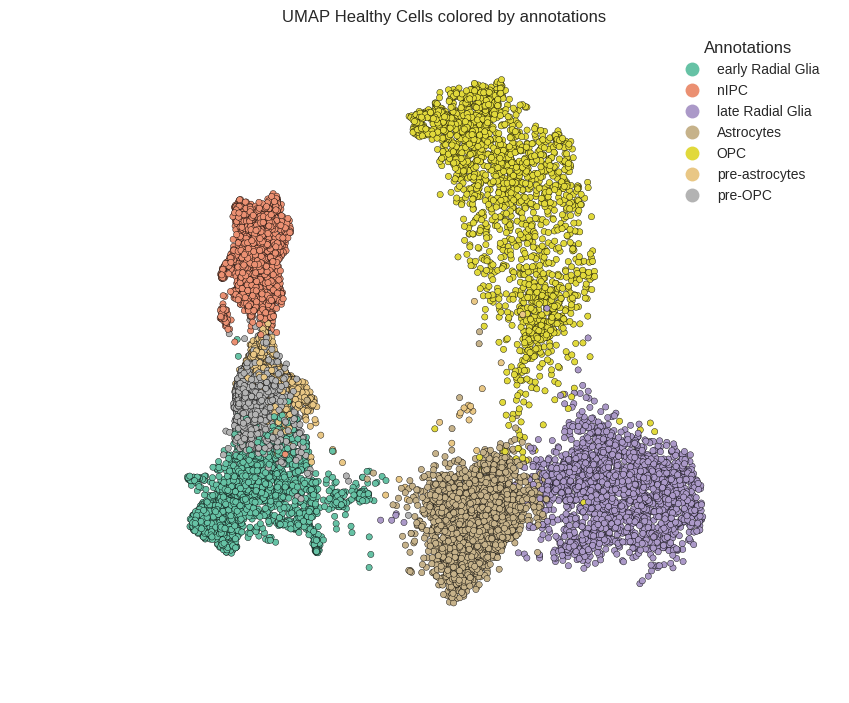

In [17]:
import numpy as np
plt.figure(figsize=(10, 8))
colors = pd.Categorical(df_healthy_UMAP['Annotations']).codes
scatter = plt.scatter(df_healthy_UMAP['DIM1'], df_healthy_UMAP['DIM2'], c=colors, cmap='Set2')

unique_annotations = df_healthy_UMAP['Annotations'].unique()
color_map = plt.cm.Set2(np.linspace(0, 1, len(unique_annotations)))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=a) 
                  for a, c in zip(unique_annotations, color_map)]
plt.legend(handles=legend_handles, title="Annotations")

plt.title('UMAP Healthy Cells colored by annotations')
plt.xlabel('DIM1')
plt.ylabel('DIM2')
plt.axis('off')
plt.show()

### Visualization of the predictions on the UMAP.
Now I will plot the UMAP of the tumor Sample SL050 8 times, one for each label for the predictions, and I will color in each plot only the cells that are predicted according to the correct category. I will do two plots, one for each classification method.

#### Random Forest Classifier

**Description of the query**: this query selects the umap cohordinates of tumor cells from UMAP table and the predictions from the Predictions table and joins them twice, once for each dimension, based on Cell_ID.

In [18]:
query_tumor_UMAP = """
SELECT 
    p.Cell_ID, 
    p.Random_Forest AS 'Random Forest', 
    um1.Coordinate AS DIM1, 
    um2.Coordinate AS DIM2
FROM 
    Predictions p
JOIN 
    UMAP um1 
    ON p.Cell_ID = um1.Cell_ID AND um1.DIM = 'DIM1'
JOIN 
    UMAP um2 
    ON p.Cell_ID = um2.Cell_ID AND um2.DIM = 'DIM2'
"""
df_tumor_UMAP  = pd.read_sql(query_tumor_UMAP, db)
df_tumor_UMAP.head()

,Cell_ID,Random Forest,DIM1,DIM2
0,10X427_3:AAACCCACATTGTCGA,pre-astrocytes,8.94140,12.06060
1,10X427_3:AAACGAAAGAGTCAAT,Astrocytes,7.53724,10.51600
2,10X427_3:AAACGCTTCGGTTAGT,early Radial Glia,8.90721,11.73360
3,10X427_3:AAAGGGCTCTACTATC,early Radial Glia,7.09201,9.35107
4,10X427_3:AAAGGTAGTGCCCGTA,subcortical nIPC,5.81512,12.77610


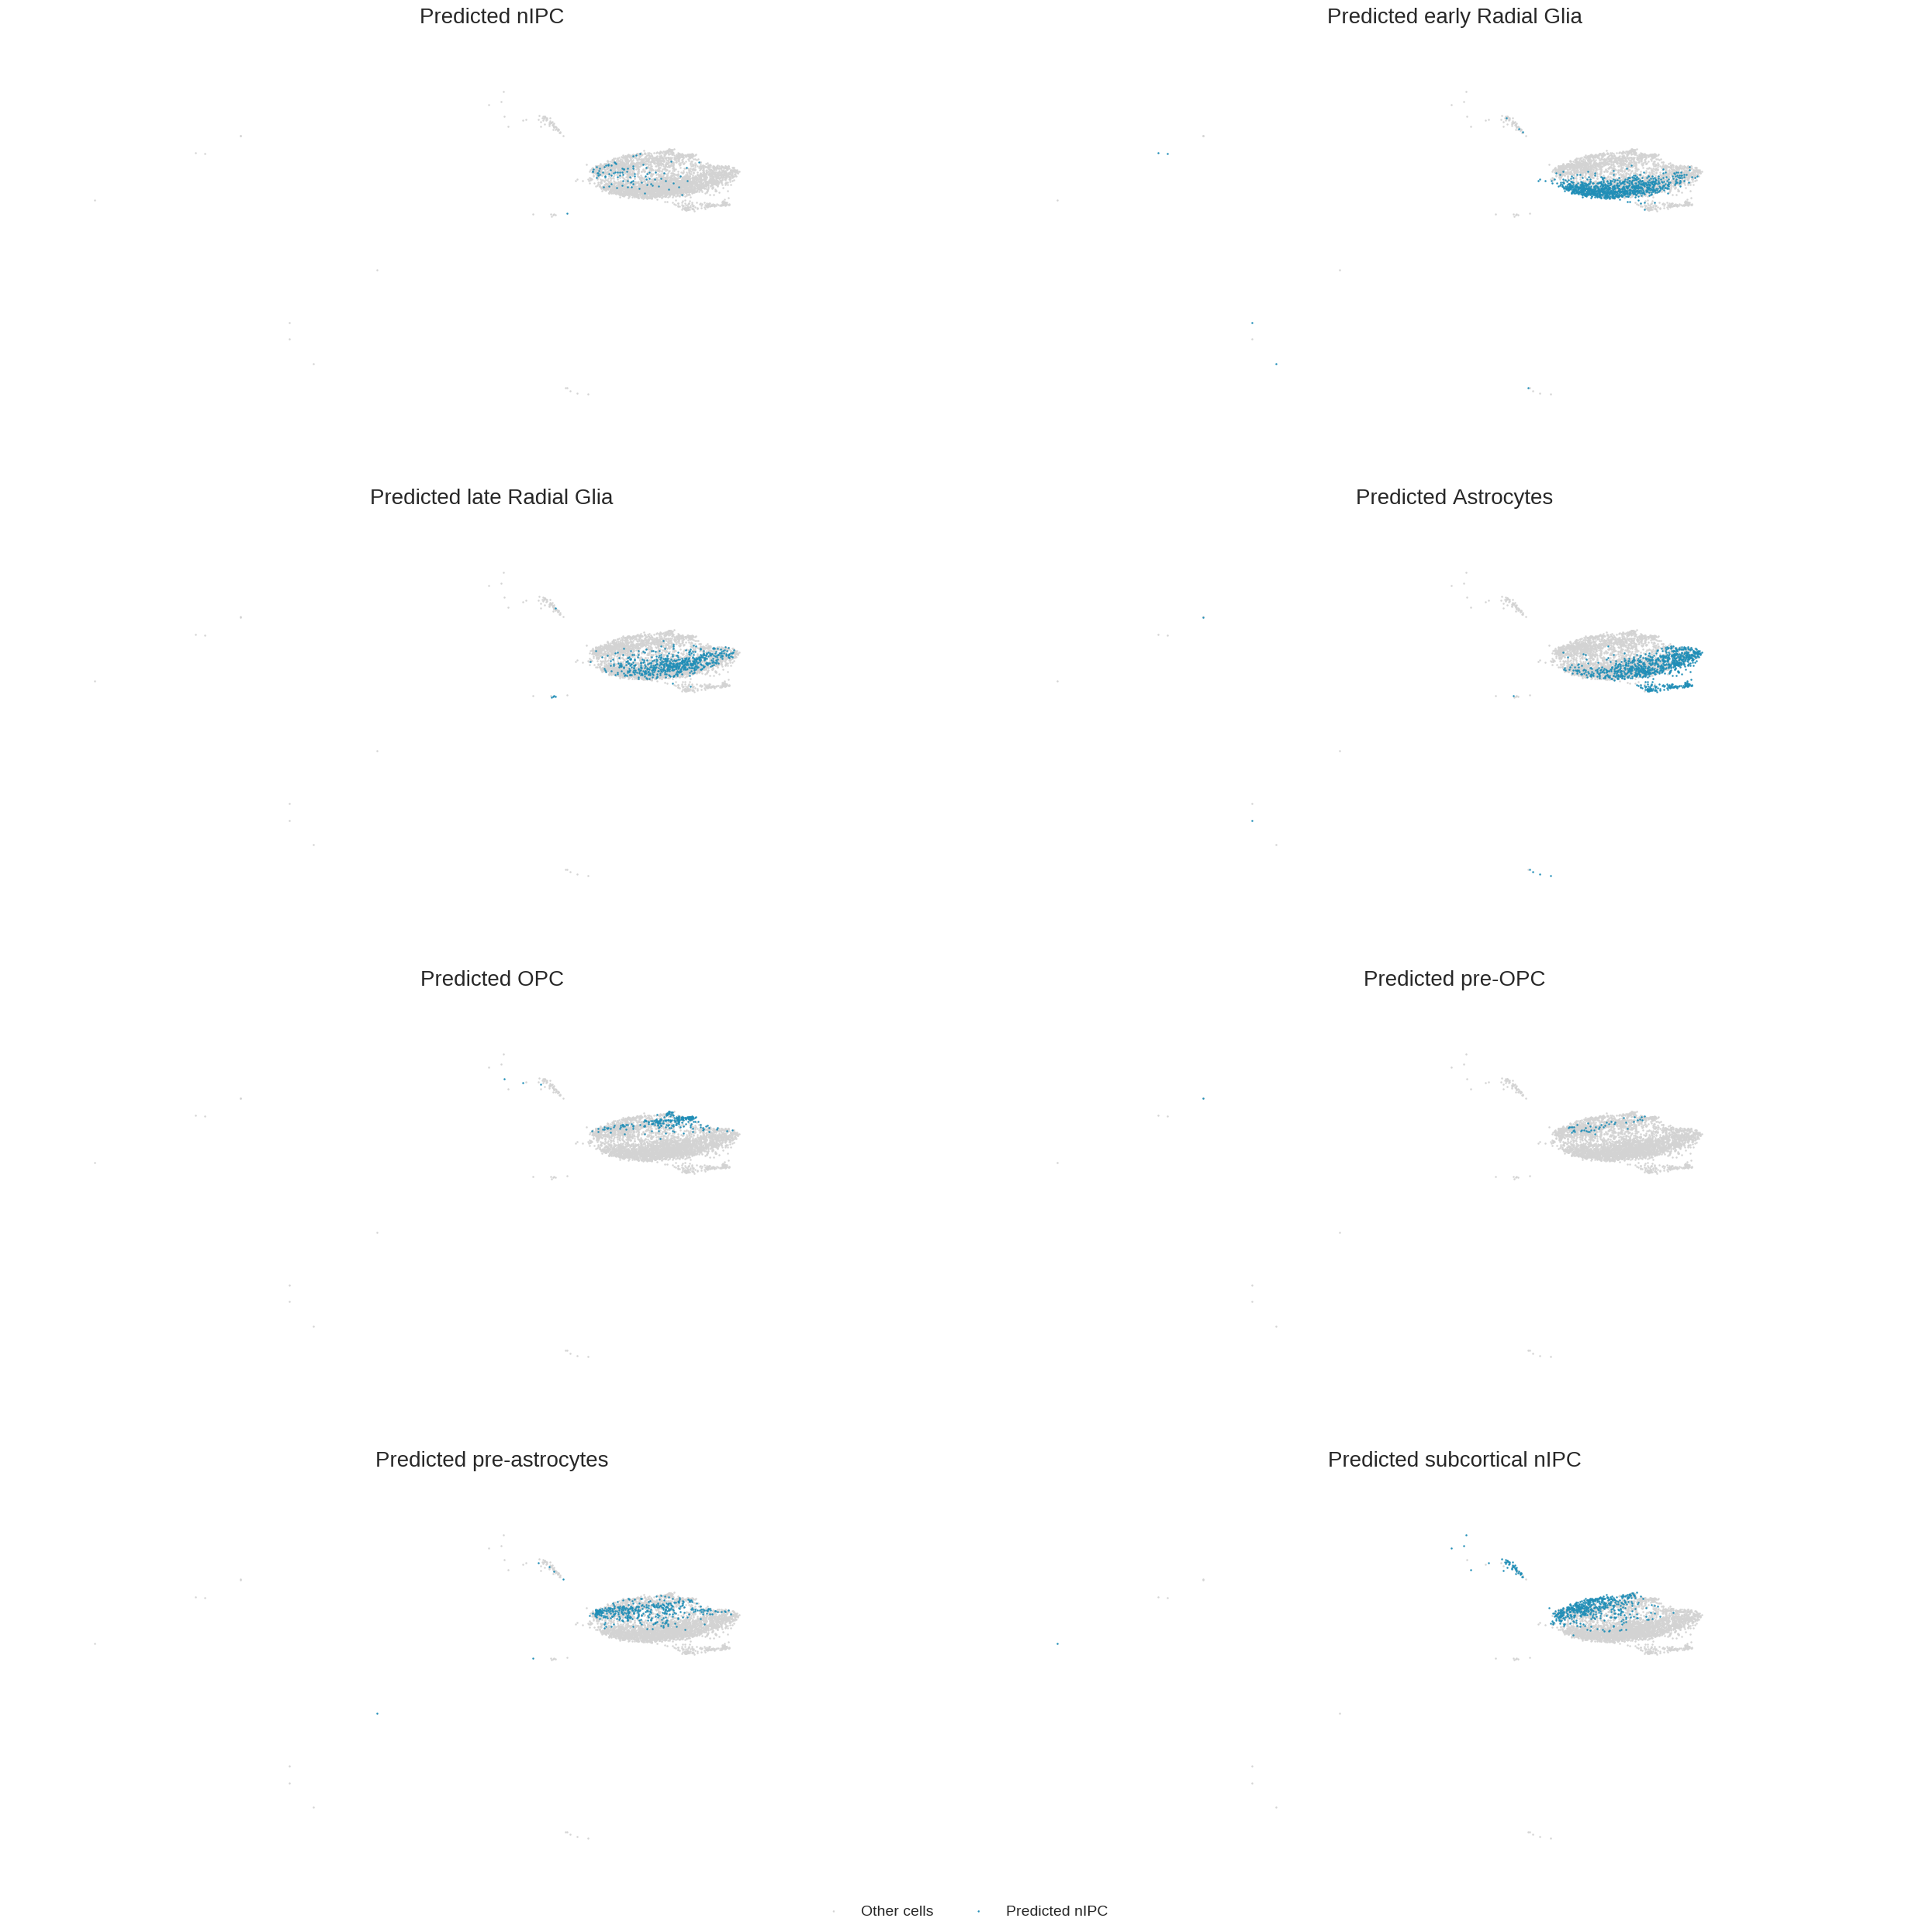

In [19]:
expected_classes = [ 'nIPC', 'early Radial Glia', 'late Radial Glia', 'Astrocytes', 'OPC', 'pre-OPC', 'pre-astrocytes', 'subcortical nIPC']
unique_predictions = df_tumor_UMAP['Random Forest'].unique()
n_rows = 4
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 25))
axs = axs.flatten()
for i, prediction in enumerate(expected_classes):
    ax = axs[i]
    is_other_cells = df_tumor_UMAP['Random Forest'] != prediction
    ax.scatter(df_tumor_UMAP.loc[is_other_cells, 'DIM1'], df_tumor_UMAP.loc[is_other_cells, 'DIM2'], s=2, color="lightgray", label='Other cells')
    
    is_predicted_class = df_tumor_UMAP['Random Forest'] == prediction
    ax.scatter(df_tumor_UMAP.loc[is_predicted_class, 'DIM1'], df_tumor_UMAP.loc[is_predicted_class, 'DIM2'], s=2, color='#208eb7', label='Predicted {}'.format(prediction))
    
    ax.set_title(label='Predicted {}'.format(prediction), fontsize=20)
    ax.axis('off')
    
for ax in axs[len(unique_predictions):]:
    ax.axis('off')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14)

plt.tight_layout()
plt.show()

#### Mahalanobis distance-based classifier

In [20]:
query_tumor_UMAPM = """
SELECT 
    p.Cell_ID, 
    p.Mahalanobis, 
    um1.Coordinate AS DIM1, 
    um2.Coordinate AS DIM2
FROM 
    Predictions p
JOIN 
    UMAP um1 
    ON p.Cell_ID = um1.Cell_ID AND um1.DIM = 'DIM1'
JOIN 
    UMAP um2 
    ON p.Cell_ID = um2.Cell_ID AND um2.DIM = 'DIM2'
"""

df_tumor_UMAPM  = pd.read_sql(query_tumor_UMAPM, db)
df_tumor_UMAPM.head()

,Cell_ID,Mahalanobis,DIM1,DIM2
0,10X427_3:AAACCCACATTGTCGA,Astrocytes,8.94140,12.06060
1,10X427_3:AAACGAAAGAGTCAAT,pre-astrocytes,7.53724,10.51600
2,10X427_3:AAACGCTTCGGTTAGT,pre-astrocytes,8.90721,11.73360
3,10X427_3:AAAGGGCTCTACTATC,Astrocytes,7.09201,9.35107
4,10X427_3:AAAGGTAGTGCCCGTA,OPC,5.81512,12.77610


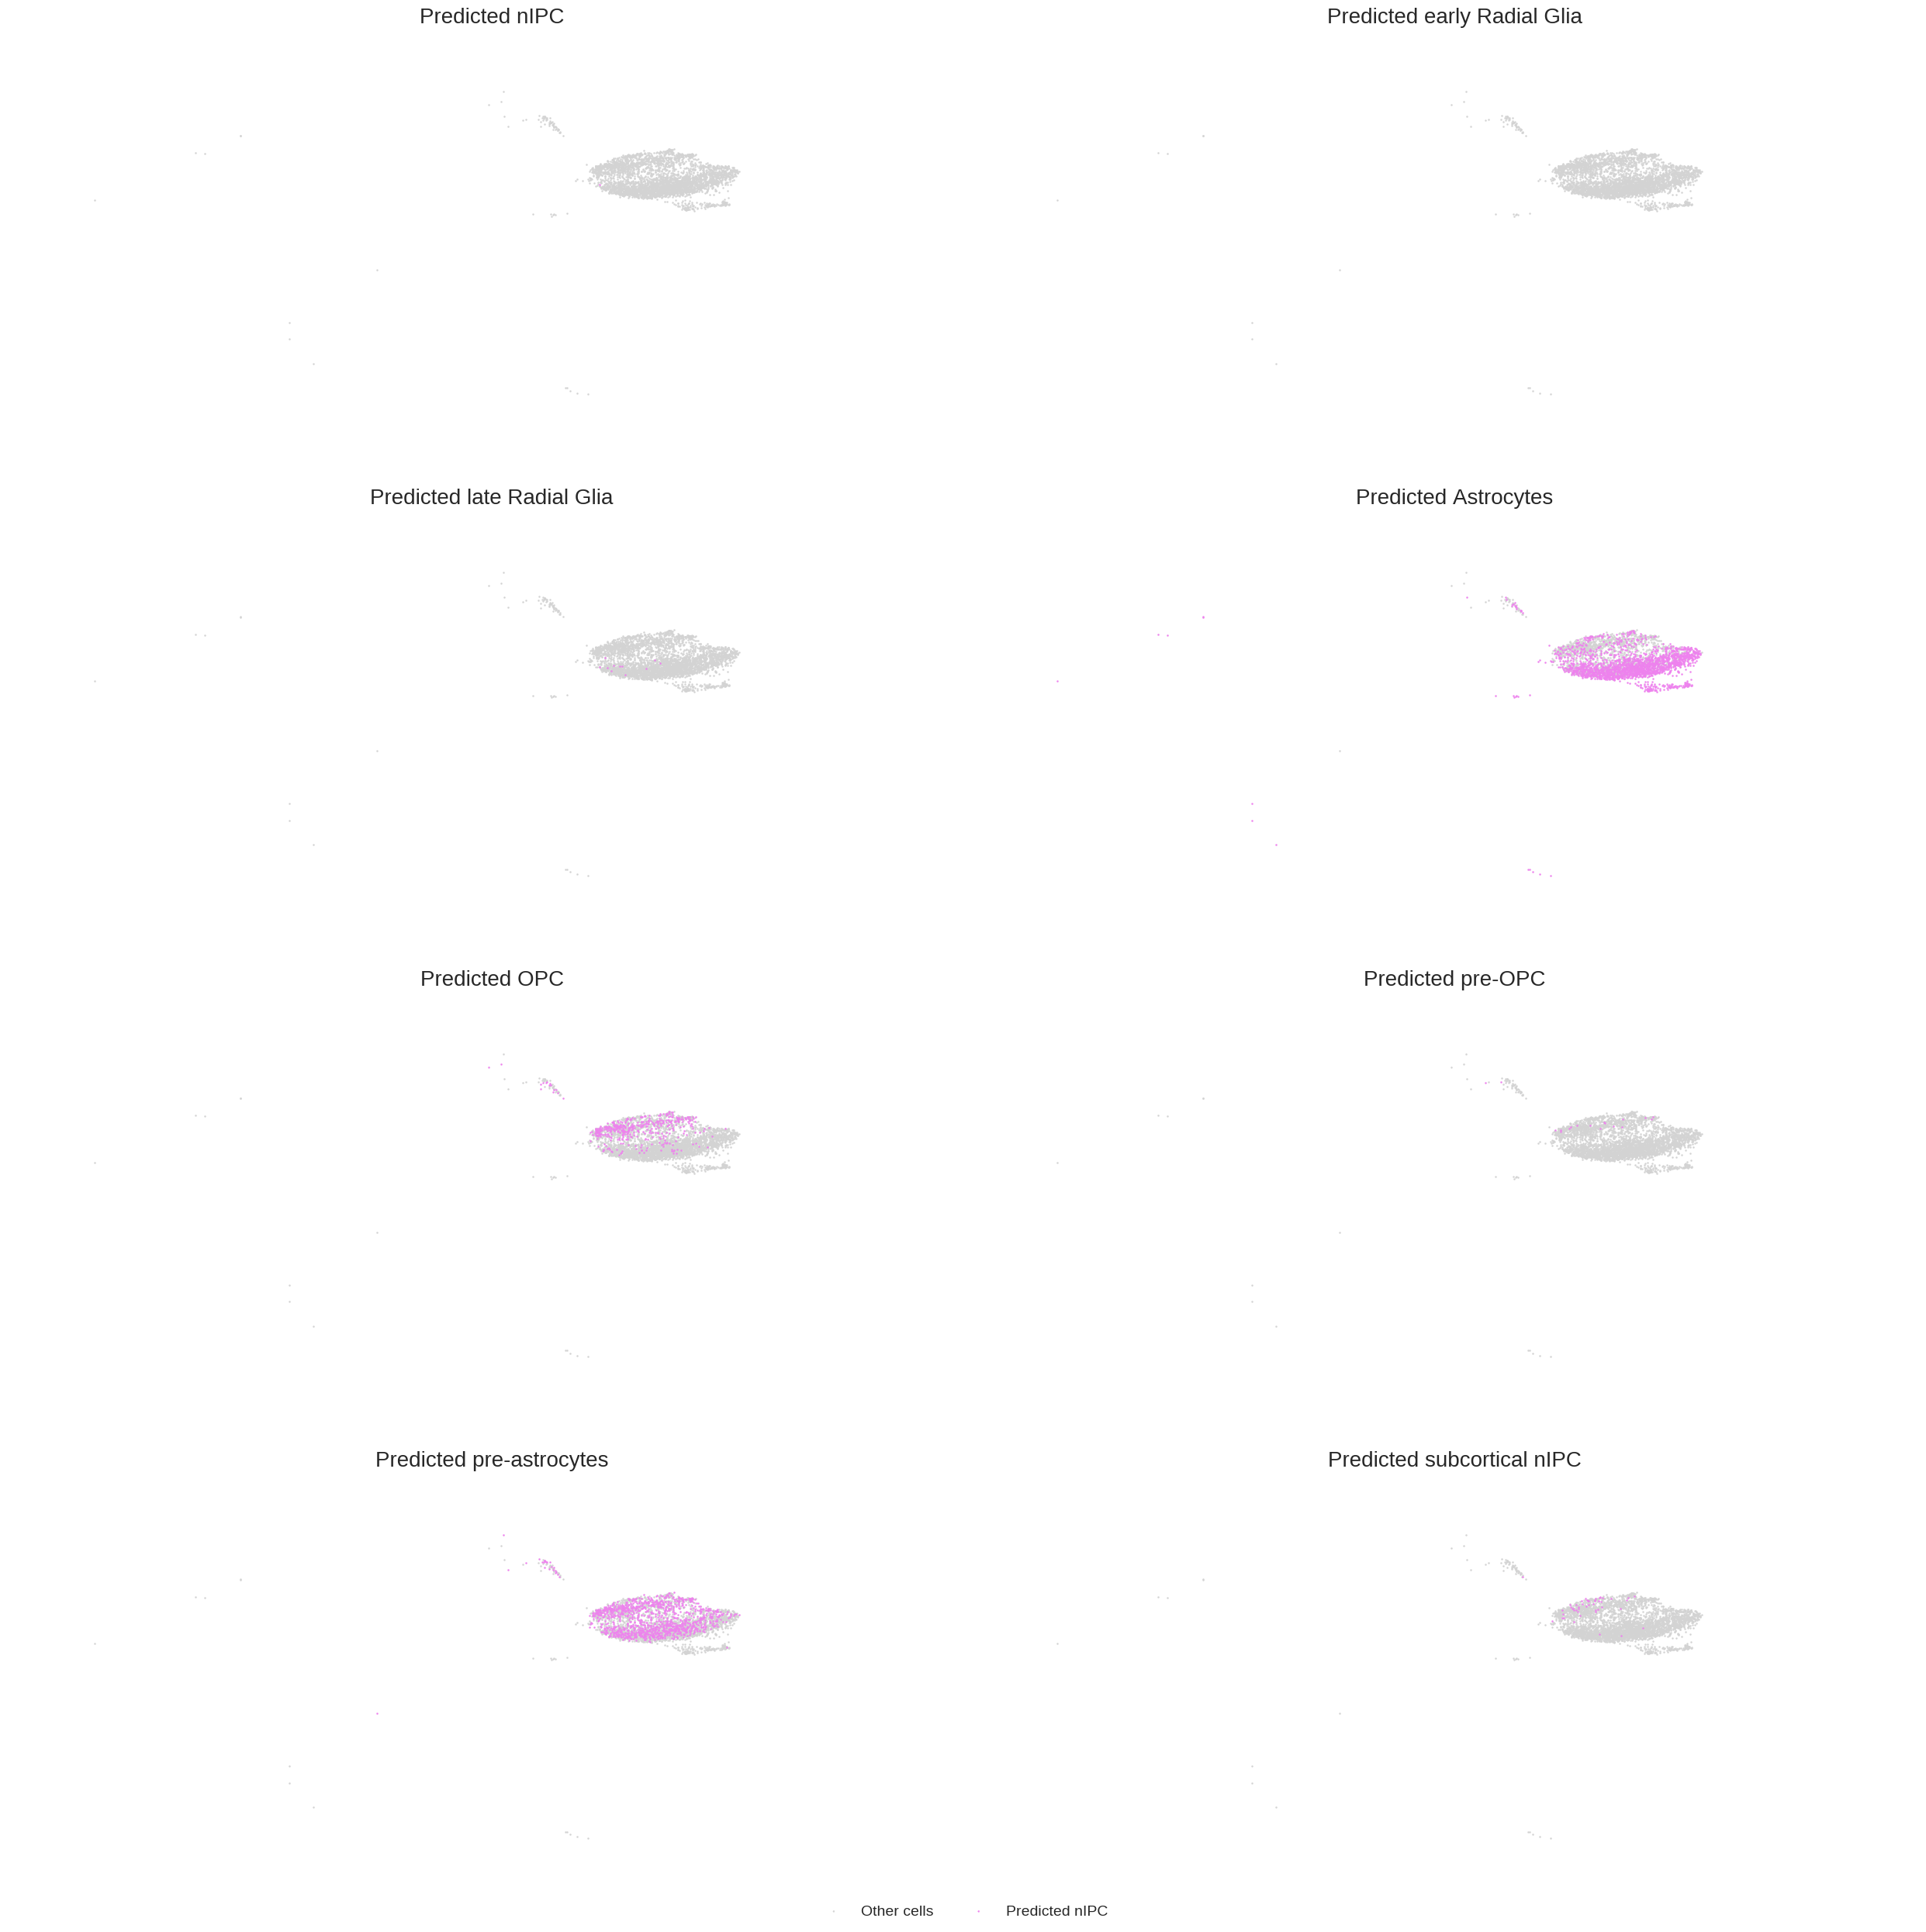

In [21]:
expected_classes = [ 'nIPC', 'early Radial Glia', 'late Radial Glia', 'Astrocytes', 'OPC', 'pre-OPC', 'pre-astrocytes', 'subcortical nIPC']
unique_predictions = df_tumor_UMAPM['Mahalanobis'].unique()
n_rows = 4
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 25))
axs = axs.flatten()
for i, prediction in enumerate(expected_classes):
    ax = axs[i]
    is_other_cells = df_tumor_UMAPM['Mahalanobis'] != prediction
    ax.scatter(df_tumor_UMAPM.loc[is_other_cells, 'DIM1'], df_tumor_UMAPM.loc[is_other_cells, 'DIM2'], s=2, color="lightgray", label='Other cells')
    
    is_predicted_class = df_tumor_UMAPM['Mahalanobis'] == prediction
    ax.scatter(df_tumor_UMAPM.loc[is_predicted_class, 'DIM1'], df_tumor_UMAPM.loc[is_predicted_class, 'DIM2'], s=2, color='violet', label='Predicted {}'.format(prediction))
    
    ax.set_title(label='Predicted {}'.format(prediction), fontsize=20)
    ax.axis('off')
    
for ax in axs[len(unique_predictions):]:
    ax.axis('off')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14)

plt.tight_layout()
plt.show()

**Description of the query**: It retrieves Cell_ID, umaps cohordinates from UMAP and RF max probability from predictions and joins them, once for each dimension

In [22]:
query_max_prob = """
SELECT 
    p.Cell_ID, 
    um1.Coordinate AS DIM1, 
    um2.Coordinate AS DIM2,
    p.RF_max_probability AS 'RF max probability'
FROM 
    Predictions p
JOIN 
    UMAP um1 
    ON p.Cell_ID = um1.Cell_ID AND um1.DIM = 'DIM1'
JOIN 
    UMAP um2 
    ON p.Cell_ID = um2.Cell_ID AND um2.DIM = 'DIM2'
"""

df_max_prob = pd.read_sql(query_max_prob, db)

In [23]:
df_max_prob.head()

,Cell_ID,DIM1,DIM2,RF max probability
0,10X427_3:AAACCCACATTGTCGA,8.94140,12.06060,0.219290
1,10X427_3:AAACGAAAGAGTCAAT,7.53724,10.51600,0.441493
2,10X427_3:AAACGCTTCGGTTAGT,8.90721,11.73360,0.222191
3,10X427_3:AAAGGGCTCTACTATC,7.09201,9.35107,0.298734
4,10X427_3:AAAGGTAGTGCCCGTA,5.81512,12.77610,0.406826


While the predictions vary a lot in their statistics, the location on the UMAP where the predictions fall is similar along the two classifier. I think this is the best way to visualize the result of the classifications.

### Plotting the predictions max probability of the Random Forest on the UMAP
During the training of the classifier, I retrieved the max probability of the Random Forest in assigning the prediction. It means how many trees, in proportion, voted for that class.
As you can see, the proportion is low, except for a very small area in the bottom, a kind of slightly separated cluster. This cluster is classifier as Astrocytes by both classifiers. It suggest that its transcriptional profile is similar to the one of the Astrocytes in the training dataset. 

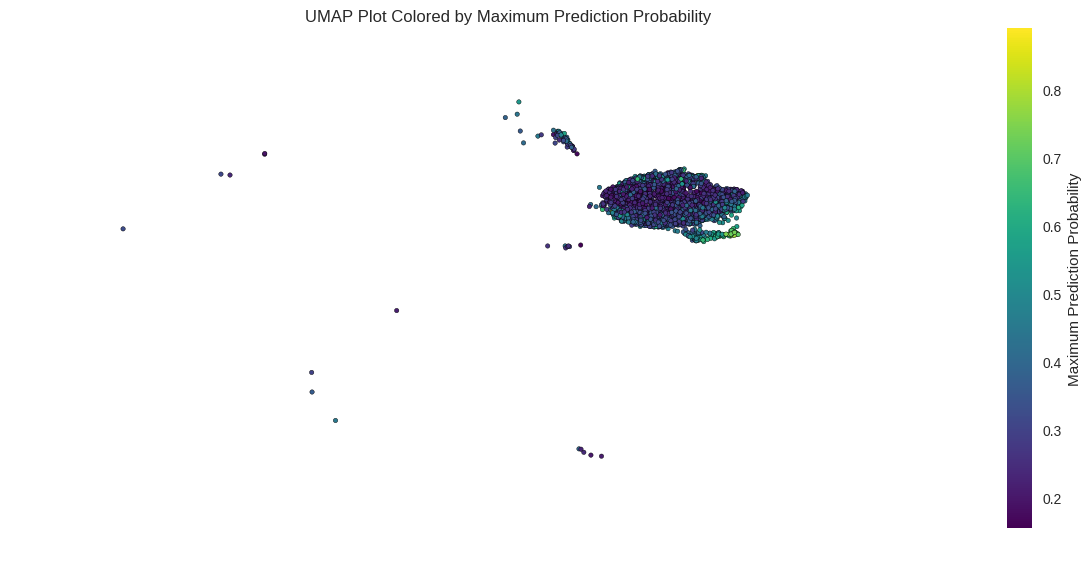

In [25]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(df_max_prob['DIM1'], df_max_prob['DIM2'], c=df_max_prob['RF max probability'], cmap='viridis', s=10)
plt.colorbar(sc, label='Maximum Prediction Probability')
plt.title('UMAP Plot Colored by Maximum Prediction Probability')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('off')
plt.tight_layout() 
plt.show()

In [26]:
cursor.close()
db.close()